In [1]:
#!/usr/bin/python
import math
from math import * 
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

from scipy import sqrt
from numba import jit
from array import *

def f(c0,c1,c2,ca):
        y=-1/2*(1+np.tanh(2*(ca-c0)))+np.tanh(2*(ca-c1))-np.tanh(2*(ca-c2))
        return y

def NAN(m,n):
    A=np.empty((m,n))
    A[:]=np.nan
    return A

def size(A):
    m=len(A)
    n=len(A[0,:])
    return [m,n]

    


In [2]:
class Pulse:
    def __init__(self, PW, PA):
        self.PW=PW
        self.PA=PA


class Source:
    def __init__(self, Res, Cap, shape):
        self.Res=Res
        self.Cap=Cap
        self.shape=shape
        
        
class Axon:
     def __init__(self, dist,diam): 
            self.dist=dist
            self.diam=diam



0.13764865102778580806

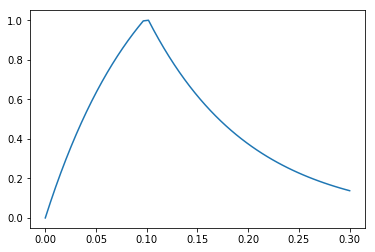

In [3]:
def PulseProfile_RC(pulse, source, Neuron_dt, Total_Rec):
    
    #Generates potential patern induced by the source
    
    num = round(Total_Rec/Neuron_dt)
    num1 = 1
    tmin = 0
    tmax = (Neuron_dt/1000)*num  #seconds
    
    t = linspace(tmin,tmax,num)
    #print(t)
    R=source.Res
    C=source.Cap
    tau=R*C
    dt=t[1]-t[0]
    #print(tau)
    
    num2 =round(pulse.PW/dt/1000)
    num2 = int(num2)

    
    V=np.float128(np.zeros(num))
    V[0:num2]=pulse.PA*R*(1-np.exp(-t[0:num2]/tau))
    V[num2:num]=pulse.PA*R*np.exp(-t[num2:num]/tau)*(np.exp(pulse.PW/tau/1000)-1)
    
    #print(t[0:num2])
    return t*1000, V/max(V)

def PulseProfile_SQ(pulse, source, Neuron_dt, Total_Rec):
    
    #Generates potential patern induced by the source
    
    num = round(Total_Rec/Neuron_dt)
    num1 = 1
    tmin = 0
    tmax = (Neuron_dt/1000)*num  #seconds
    
    t = linspace(tmin,tmax,num)
    #print(t)
    R=source.Res
    C=source.Cap
    tau=R*C
    dt=t[1]-t[0]
    #print(tau)
    
    num2 =round(pulse.PW/dt/1000)
    num2 = int(num2)

    
    V=np.zeros(num)
    V[0:num2]=1
    V[num2:num]=0
    
    #print(t[0:num2])
    return t*1000, V/max(V)
Res = 20e3
Cap = 5e-9
Neuron_dt=0.005

PW=0.1
PA=9.0e-06
pulse=Pulse(PW,PA)
source=Source(Res,Cap,'SQ')
Total_Rec=3*pulse.PW

t,v=PulseProfile_RC(pulse, source, Neuron_dt, Total_Rec)
plt.plot(t,v)
v[-1]

In [4]:
def vectrorProduct(vv,ve):
    v_stim=np.zeros([len(vv),len(ve)])

    for i in range(len(vv)):
        for j in range(len(ve)):
            v_stim[i,j]=vv[i]*ve[j]
        
    return v_stim

def Find(w,item):
    r=[]
    for i in range(len(w)):
        if w[i]==item:
            r.append(i)
            
    return r
    
        

In [5]:
def sensoryLIFE(pulse, source ,axon):
#%% Adaptive Neural Systems Laboratory (2019)
#%  Enhanced Surface Electrical Neurostimulation (eSENS)
#%  Simulations and Human Subject Studies, PhD Project by Andres E Pena
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#% Modified script based on Gaines 2018 model for TES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#% This script generates the NEURON extracellular voltage profiles
#% along the length of a sensory axon over a given time.
#% This was originally used in a full arm model of surface
#% electrical stimulation (Gaines 2018), and in that case very long axons
#% were needed. Neuron checks for an action potential in one node.
#% The start time of the stimulus is variable in Neuron.
#% This is because there is a small depolarization that happens upon
#% initialization of the model and this delay allows the membrane potential
#% to stabilize.
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#% This function is released to be used in NEURON simulations (MATLAB based profile)
#% Version: ANS-eSENS-01.03 (Andres Pena 08/02/2019)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#%% LOCAL SETUP / PARAMETERS / FLAGS
#% This sections contains main parameters relevant to this function


    NEURON_Path = '/Users/mortezarouhani/Documents/PulseProfile_app2/Sensory_Model';


    #%% Characteristics of the stimmulation source(s)
    I=-pulse.PA/1000    #Injected current in mA
    # Location of each source
    # Source A (Representing Voice 1 in stimulator)


    Ay=axon.dist      #micrometers perpendicular distance of the point source from the center of the axon.
    Az=0              #z offset. In micrometers, distance to offset the stimulus along the axon. Default is centered over the center node.
    Ax=1              #Could do an offset in the x direction
    
   
    
    PShape = source.shape  # RC or SQ
    Res = source.Res
    Cap = source.Cap
    
    # Characteristics of the simulated sensory fiber
    number_nodes=21     #Odd number is best
    fiberD=axon.diam    #um
    


    # Select where the AP will be "recorded"
    # To select Custom Node(0), Specify the node in CustomNode variable
    Where2Check = 1   # Start(1), Middle(2), or End(3) of the sensory fiber
    CustomNode = 10   # This is the node where the voltage will be checked for an action potential in NEURON.
    dt = 0.005        # in ms this is set in NEURON

    # These are in um (micrometers)
    n=1                              # node width
    m=3                              # mysa width
    f=(2.5811*fiberD)+19.59
    deltax=969.3*log(fiberD)-1144.6  #Distance between nodes
    s=(deltax-n-(2*m)-(2*f))/6       #stin width

    widths=[n, m, f, s, s, s, s, s, s, f, m]

    if number_nodes%2 == 0 :
    #number is even
        w=np.tile(widths,(number_nodes))
    #w=cat(2,w,widths(1:6));
    else:
    #number is odd
        w=np.tile(widths,(number_nodes-1)) 
        w=np.append(w,[1])
    #print(len(w))
    centers=w/2 #middle of each segement ex. middle of each node, middle of each mysa...
    z=[]

    for b in range(len(w)):
        z=np.append(z,[centers[b]+np.sum(w[0:b])-centers[0]]) #um z=transvers distance up and down the arm from the point source to the position on the axon
    #print(len(z))
    cond_long=1/(3e6)  #ohm*um longitudinal conductivity
    cond_trans=1/(1.2e7) #ohm*um transverse conductivity
    #?????????????????? OR Simens/um
    #the uniform media:
    #cond_long=cond_trans;

    # A
    #Calculates voltage along nerve at the center of each segment (z)

    #Ve_A=I./(4*pi*sqrt((Ax.^2*cond_long*cond_trans)'+(Ay.^2*cond_long*cond_trans)'+(z.^2*cond_trans^2)'))';  %voltage in mV


    Ve = zeros(len(w))
    Ve = I/(4*pi*sqrt(Ax*Ax*cond_long*cond_trans+Ay*Ay*cond_long*cond_trans+np.multiply(z,z)*cond_trans**2))
    #print(Ve)
    #voltage of A in mV
    #Ve(2,:) = I./(4*pi*sqrt((Bx.^2*cond_long*cond_trans)'+(By.^2*cond_long*cond_trans)'+(z.^2*cond_trans^2)'))';  %voltage of B in mV



        
    # PlotFlag = 'plot';
    PlotFlag = 'noplot'
    RC_vals = [Res, Cap]
    RC_Tau_ms = 1000*Res*Cap
        
        
    EV_Duration = 2*pulse.PW+RC_Tau_ms    # in ms, Duration of the extracellular potential recording from COMSOL
        
    ProfileDur = round(EV_Duration/dt)
    #print(ProfileDur)
        
    TT = zeros(ProfileDur) 
    VV = zeros(ProfileDur)

    if PShape=='SQ':
        TT,VV = PulseProfile_SQ(pulse, source, dt, EV_Duration)
    else:
        TT,VV = PulseProfile_RC(pulse, source, dt, EV_Duration)   
        

    Fdist = z #Distance vector to simulate (um)
    Simulated_V = zeros([len(Fdist),len(TT)+1])
        
        #         VV_Sim = VV'.*Simulated_V(:,2);
        
    VV_Sim = vectrorProduct(VV,Ve)
    #print(size(VV_Sim))
    V_left= fliplr(VV_Sim)
    VVV=np.delete(VV_Sim,0,1)
    #print(size(VVV))
    V_final=np.concatenate((V_left,np.delete(VV_Sim,0,1)), axis=1)
    #print(size(V_left))
   # w_left=w[::-1]
    #w_final=np.concatenate((w_left,w[1:len(w)]),axis=0)
    w_final=w

    nodes=Find(w_final,n)
    mysas=Find(w_final,m)
    fluts=Find(w_final,f)
    stins=Find(w_final,s)
    
    v_nodes=V_final[:,nodes]
    v_mysas=V_final[:,mysas]
    v_fluts=V_final[:,fluts]
    v_stins=V_final[:,stins]
    
    
    return w_final,V_final,v_nodes, v_mysas,v_fluts, v_stins

      


In [6]:

diam=range(6,16,1)

hist=np.array([6.1,5.1,6.1,10.2,16.3,20.4,21.4,7.2,4.1,3.1])


fiberNum=134
radii=np.zeros(fiberNum)
trgt1=np.round(fiberNum/100*hist)
trgt=trgt1.astype(int)
k=0
for i in range(len(diam)): 
     for j in range(trgt[i]):
        radii[k]=diam[i]/2
        k=k+1

k=0
radii

array([3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3.5, 3.5, 3.5, 3.5, 3.5,
       3.5, 3.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4.5, 4.5, 4.5,
       4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5. , 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5.5, 5.5, 5.5, 5.5, 5.5, 5.5,
       5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5,
       5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 6. , 6. , 6. , 6. , 6. ,
       6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. ,
       6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6. , 6.5, 6.5,
       6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 7. , 7. , 7. , 7. , 7. ,
       7.5, 7.5, 7.5, 7.5])

In [7]:
from pprint import pprint as pp
from astropy.io import ascii
import os
s=''
import circlify as circ
circles = circ.circlify(list(radii+0.25), show_enclosure=True)
for i in range(len(radii)):
    s=s+str(circles[i])
s=s.replace('Circle(','')
s=s.replace('ex=None)','')
s=s.replace('y=','')
s=s.replace('x=','')
s=s.replace('r=','')
s=s.replace('level=0,','')
s=s.replace('level=1,','')
s=s.replace(' ','')
ss=s[0:len(s)-1]
#s=s.replace(',','')
x=np.zeros(fiberNum)
y=np.zeros(fiberNum)
r=np.zeros(fiberNum)
circles=np.zeros((fiberNum,3))
fiberNumbr=np.zeros(1) #np.empty([2,1],dtype=int)
fiberNumbr[0]=str(int(fiberNum))
print((fiberNumbr))
p=0
j=0
for k in ss.split(','):
    circles[p//3][p%3]=float(k)
    p=p+1
q=radii[-1]/circles[fiberNum-1][2]

crcl = NAN(fiberNum,5)

FBNUM=np.array([fiberNum])

crcl[1:fiberNum,2:5]=q*circles[1:fiberNum,:]
crcl[0,0]=fiberNum-1
crcl[0,1]=3

#os.chdir('Sensory_Model')   
#np.savetxt('circles.dat', q*circles  , delimiter=' ',newline=' \n  NaN  NaN',encoding='str')
#np.savetxt('fiberNum.dat', fiberNumbr)
ascii.write(crcl,'circles.dat',overwrite=True)
ascii.write(FBNUM,'fiberNum.dat',overwrite=True)

[134.]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


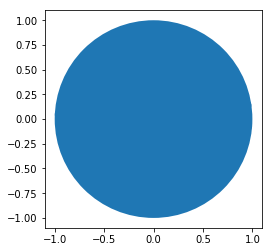

In [8]:
import matplotlib.pyplot as plt

def create_circle(x,y,r):
	circle= plt.Circle((x,y), radius= r)
	return circle

def show_shape(patch):
	ax=plt.gca()
	ax.add_patch(patch)
	plt.axis('scaled')
	#plt.show()

for i in range(fiberNum):
    show_shape(create_circle(circles[i][0],circles[i][1],circles[i][2]))
    plt.hold(True)
plt.show()

In [9]:
Res = 20e3
Cap = 5e-9
Neuron_dt=0.005

PW=0.1
PA=40
pulse=Pulse(PW,PA)
source=Source(Res,Cap,'SQ')
Total_Rec=3*pulse.PW
fiberD=10
distance=100
axon=Axon(distance,fiberD)
w,V,n,m,f,s=sensoryLIFE(pulse, source ,axon)
#np.savetxt('nodesTest.dat', n, delimiter=' ',newline='   NAN  NAN  \n')

In [10]:
from neuron import h, gui
# Model Globals

axonnodes=21
celsius=37		#degrees C#	# Human body temperature
v_init=-79.3565 #mV#          # starting voltage
dt=0.005 #ms#                  # time step
tstop=25 #ms#                # time at which simulation terminates
	#node_volt #mV#                # voltage profile in the node from MAXWELL
	#mysa_volt #mV#                # voltage profile in the mysa from MAXWELL
	#flut_volt #mV#                # voltage profile in the flut from MAXWELL
	#stin_volt #mV#                # voltage profile in the stin from MAXWELL
	#fiberDiam  #um#                # Diameter of the axon fiber
    #	num_nodes                       # Number of nodes modeled


#Extracellular stimuluation parameters#
delay=15 #ms           # time before the stimulation is applied
pw=.5	#ms            # pulse width, the duration of the stimulation

#topological parameters#
paranodes1=(axonnodes-1)*2#156_40_156 (nodes-1)*2      # number of mysa segments in the axon model
paranodes2=(axonnodes-1)*2#156_40_156 (nodes-1)*2      # number of flut segments in the axon model
axoninter=(axonnodes-1)*6#468_120_468                  # number of stin segments in the axon model
axontotal=axonnodes+paranodes1+paranodes2+axoninter     # total number of segments in the axon model

#morphological parameters#
lm=3       # mysa length
ln=1.0      # node length
space_p1=0.002      # mysa periaxonal space width
space_p2=0.004      # flut periaxonal space width
space_i=0.004       # stin periaxonal space width

#electrical parameters#
rhoa=0.7e6 #Ohm-um#                       #axoplasmic resistivity
mycm=0.1 #uF/cm2/lamella membrane#    # myelin capacitance
mygm=0.001 #S/cm2/lamella membrane#   # myelin conductance

# number of fibers
	#fiberNum=3
#h("create(node[fiberNum][axonnodes],MYSA1[fiberNum][paranodes1],MYSA2[fiberNum][paranodes1]")
#h.create(FLUT1[fiberNum][paranodes2],FLUT2[fiberNum][paranodes2], STIN[fiberNum][axoninter])
#print(dir(h))
'''
for k in range(fiberNum):
		
		for i in range(axonnodes):
			fiberDiam[k]=centers[k][2]
            
			h.access node[k][i]
				nseg=1
				#diam=nodeD
				#L=ln
				pt3dadd(centers[k][0],centers[k][1],(k)*ltotal[k], nodeD[k])
				pt3dadd(centers[k][0],centers[k][1],(k)*ltotal[k]+ln, nodeD[k])

				Ra=rhoa/10000
				cm=2
				insert node_sensory       # mod file declaring nodal channel properties
				xraxial=Rpn0[k] xg=1e10 xc=0
				
			
#h.pt3dadd(0,0,5,20)
#h.pt3dadd(0,0,100,10)
#h.load_file('BlenderNEURON.hoc')
'''

print(fiberNum,axonnodes,fiberNum,paranodes1,fiberNum,paranodes1)

#MYSA1[fiberNum][paranodes1]


134 21 134 40 134 40


In [38]:
fiberNum,axonnodes = (134,21)

h("fiberNum ="+str(fiberNum))
h("axonnodes ="+str(axonnodes))

h.fiberNum
h.axonnodes
h("create node[fiberNum][axonnodes]")
print("node" in dir(h.node))

node = h.node
print(type(node))

print(node)
#print(dir(node))


import numpy as np
h('nrnpython("a = [i for i in range(0,9)]")')
a

True
<class 'hoc.HocObject'>
node[?]
	1 
1 


[0, 1, 2, 3, 4, 5, 6, 7, 8]

	1 
1 


[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
h("create(node["+str(fiberNum)+"]"+str(axonnodes)+

In [ ]:
from neuron import h, gui
h.load_file('TES_Sensory_AP.hoc')


In [ ]:
Fiber


In [ ]:
result

In [ ]:
a=([1,2,4,4,6,7])
ar=np.array(a)
ar+2


In [ ]:
a[:,[1:3]]

In [ ]:
a=np.array([])
np.append(a,2)
np.append(a,20)
np.append(a,200)


In [ ]:
f = open('cell.hoc', 'r')
dta=f.read()


In [ ]:
acsii.write()

x=np.zeros(1)

In [ ]:
x[0]=4

In [ ]:
x